In [1]:
from abmax.structs import *
from abmax.functions import *
import jax.numpy as jnp
import jax.random as random
import jax
from flax import struct

In [2]:
DT = 0.1 # Time step for simulation
KEY = jax.random.PRNGKey(0)
Num_steps = 200

In [3]:
# Order params
ORDER_AGENT_TYPE = 0
MAX_NUM_ORDERS = 10000
BUY_ORDER_POLARITY = jnp.array([0], dtype=jnp.int32)
SELL_ORDER_POLARITY = jnp.array([1], dtype=jnp.int32)
STARTING_PRICE = 100.0

#trader params
MAX_NUM_TRADERS = 100
TRADER_AGENT_TYPE = 1

In [4]:

Market_create_params = Params(content={"num_traders": MAX_NUM_TRADERS, "trader_agent_type": TRADER_AGENT_TYPE, "starting_price": STARTING_PRICE, "max_num_orders": MAX_NUM_ORDERS,
                                       "order_agent_type": ORDER_AGENT_TYPE, "buy_order_polarity": BUY_ORDER_POLARITY, "sell_order_polarity": SELL_ORDER_POLARITY})


In [5]:
@struct.dataclass
class Order(Agent):
    @staticmethod
    def create_agent(type, params, id, active_state, key):
        '''
        Create a blank order agent, assumption: active_state is false
        '''
        num_shares = jnp.array([0])  # number of shares remaining in the order # dont put -1 as cumsum will not work
        remove_flag = jnp.array([0]) # flag to indicate if the order is removed
        agent_state_content = {"num_shares": num_shares, "remove_flag": remove_flag}
        agent_state = State(content=agent_state_content) 

        
        polarity = params.content["polarity"] #params.content["polarity"] # jnp.array([0]) -> buy, jnp.array([1]) ->sell
        price = jax.lax.cond(polarity[0] == 0, lambda _: jnp.array([0.0]), lambda _: jnp.array([1000.0]), None)        
        trader_id = jnp.array([-1]) # id of the trader who placed the order, -1 for inactive orders

        agent_params = Params(content = {"polarity": polarity, "price": price, "trader_id": trader_id})

        agent = Order(agent_type=type, params=agent_params, id=id, active_state=active_state, 
                      state=agent_state, policy=None, key=key, age = 0.0)
        return agent
        

    @staticmethod
    def step_agent(agent, input, step_params):
        '''
        deplete the number of shares remaining in the order by the input amount
        '''
        def step_active_agent():
            num_shares_remove = input.content["num_shares_remove"]
            num_shares = agent.state.content["num_shares"]
            
            num_shares = jnp.maximum(num_shares - num_shares_remove, 0)
            remove_flag = jax.lax.cond(num_shares[0] == 0,
                                      lambda _: jnp.array([1]), 
                                      lambda _: jnp.array([0]), None)
            agent_state_content = {"num_shares": num_shares, "remove_flag": remove_flag}
            agent_state = State(content=agent_state_content)

            dt = step_params.content["dt"]
            return agent.replace(state=agent_state, age=agent.age + dt)
        
        def step_inactive_agent():
            # Inactive agents do not change state, just return the agent as is
            return agent
        
        return jax.lax.cond(agent.active_state, lambda _: step_active_agent(), 
                            lambda _: step_inactive_agent(), None)


    @staticmethod
    def remove_agent(agents, idx, remove_params):
        '''
        replace a depleted order agent with blank order agent
        '''
        order_to_remove = jax.tree_util.tree_map(lambda x: x[idx], agents)

        num_shares = jnp.array([0]) # don't put -1 as cumsum will not work
        remove_flag = jnp.array([0]) 
        agent_state_content = {"num_shares": num_shares, "remove_flag": remove_flag}
        agent_state = State(content=agent_state_content)

        polarity = order_to_remove.params.content["polarity"]
        price = jax.lax.cond(polarity[0] == 0, lambda _: jnp.array([0.0]), lambda _: jnp.array([1000.0]), None)
        trader_id = jnp.array([-1])
        agent_params = Params(content = {"polarity": polarity, "price": price, "trader_id": trader_id})

        return order_to_remove.replace( state = agent_state, params = agent_params, 
                                        active_state = False, age = 0.0)
    

    @staticmethod
    def add_agent(agents, idx, add_params):
        '''
        add a new order at idx with the given params
        '''
        order_to_add = jax.tree_util.tree_map(lambda x: x[idx], agents)
        
        num_active_agents = add_params.content["num_active_agents"]
        param_idx = idx - num_active_agents # To add agents in correct place 

        trader_id = add_params.content["trader_id_list"][param_idx] # which trader has placed the order
        price = add_params.content["price_list"][param_idx] # whats the price of the order
        num_shares = add_params.content["num_shares_list"][param_idx] # how many shares in the order
        
        polarity = order_to_add.params.content["polarity"]
        
        remove_flag = jnp.array([0])
        agent_state = State(content={"num_shares": num_shares, "remove_flag": remove_flag})

        agent_params = Params(content = {"polarity": polarity, "price": price, "trader_id": trader_id})

        return order_to_add.replace(state=agent_state, params=agent_params, active_state=True, age=0.0)

In [6]:
@struct.dataclass
class Social_Network(Policy):
    @staticmethod
    def create_policy(params:Params, key:jax.random.PRNGKey):
        
        num_traders = params.content["num_traders"]
        key, subkey = jax.random.split(key)
        
        trust_weights_not_normalized = jax.random.uniform(subkey, (num_traders, 1), minval=0.0, maxval=1.0)
        trust_weights_norm = trust_weights_not_normalized / jnp.sum(trust_weights_not_normalized, axis = 0, keepdims= True)
        policy_params = Params(content={"trust_weights": trust_weights_norm})
        
        
        belief = params.content["starting_price"]
        belief_errors = jnp.zeros((num_traders, 1))  # shape (num_traders, 1)
        policy_state = State(content={"belief": belief, "belief_errors": belief_errors})
        
        return Policy( params=policy_params, state=policy_state, key=key)
    
    @staticmethod
    def step_policy(policy:Policy, input:Signal):
        trader_beliefs = input.content["trader_beliefs"]  # shape (num_traders, 1)
        lob_price = input.content["lob_price"]

        trust_weights = policy.params.content["trust_weights"]
        previous_belief = policy.state.content["belief"]
        previous_belief_errors = policy.state.content["belief_errors"]
        
        # Calculate the weighted average of trader beliefs
        # Note: one of the trader is the subject agent itself, thus we dont need any special mechanism for recurrence
    

        #belief = jax.random.uniform(subkey, (1,), minval=-1.0, maxval=1.0) + previous_belief 
        belief_via_trust = jnp.sum(trader_beliefs * trust_weights, axis = 0) / jnp.sum(trust_weights, axis = 0)
        delta = belief_via_trust / 100

        key, subkey = jax.random.split(policy.key)
        flip = jax.random.bernoulli(subkey, 0.5, shape = (1,))
        sign = jnp.where(flip, 1.0,-1.0)
        signed_delta = delta * sign

        belief = previous_belief + signed_delta


        # Update the belief error
        belief_errors = previous_belief_errors + jnp.abs(trader_beliefs - lob_price)

        # when a belief error exceeds a threhold, we update the trust weights
        # for that we can do a simple weight update in the direction of the belief error or use jax.grad to compute the gradient
        # instead of favouring the trader with the lowest error, we can also favour the trader with highest profit, or more history of profit
        
        
        return policy.replace(state=policy.state.replace(content={"belief": belief, "belief_errors": belief_errors}),
                              key=key)

In [7]:
@struct.dataclass
class Trader(Agent):
    @staticmethod
    def create_agent(type, params, id, active_state, key):
        key, *create_keys = random.split(key, 5)
        
        policy = params.content["policy"] # policy.params contains the trust weights and policy.state contains some sort of price belief

        # cash = jax.random.uniform(create_keys[0], (1,), minval=1000.0, maxval=10000.0)
        # shares = jax.random.randint(create_keys[1], (1,), minval=10, maxval=100)
        
        starting_price = params.content["starting_price"]
        belief_span = params.content["belief_span"]
        lower_price = starting_price * (1.0 - belief_span)
        upper_price = starting_price * (1.0 + belief_span)
        
        belief = jax.random.uniform(create_keys[0], (1,), minval=lower_price, maxval=upper_price)
        
        # if params.content["trader_type"] == -1, choose a random trader type: 0-> manipulator, 1-> trend_follower 2->fundamentalist
        trader_type = jax.lax.cond(params.content["trader_type"][0] == -1,
                                   lambda _: jax.random.randint(create_keys[1], (1,), minval=0, maxval=3),
                                   lambda _: params.content["trader_type"], None)
        
        # determine the cash and shares based on the trader type, cash: F-> around 10^3, T-> around 10^4.5, W-> around 10^6
        # shares: F-> around 10^2, T-> around 10^3, W-> around 10^4
        cash_samplers = [lambda _: jax.random.uniform(create_keys[2], (1,), minval=2.7, maxval=3.3), # A list of functions (one for each trader)
                         lambda _: jax.random.uniform(create_keys[2], (1,), minval=4.2, maxval=4.8),
                         lambda _: jax.random.uniform(create_keys[2], (1,), minval=5.7, maxval=6.3)]
        cash_power = jax.lax.switch(trader_type[0], cash_samplers, None)
        cash = jnp.array([jnp.power(10.0, cash_power[0])])  # cash is a power of 10 based on trader type

        shares_samplers = [lambda _: jax.random.uniform(create_keys[3], (1,), minval=1.7, maxval=2.3), 
                           lambda _: jax.random.uniform(create_keys[3], (1,), minval=2.7, maxval=3.3),
                           lambda _: jax.random.uniform(create_keys[3], (1,), minval=3.7, maxval=4.3)]
        shares_power = jax.lax.switch(trader_type[0], shares_samplers, None)
        shares = (jnp.power(10.0, shares_power[0]))  # shares is a power of 10 based on trader type
        #convert shares to int
        shares = jnp.round(shares).astype(jnp.int32)  # round to nearest integer
        shares = jnp.array([shares])  # make it a JAX array        
        
        buy_flag = jnp.array([False])  # initialize buy_flag as a JAX array
        buy_num_shares = jnp.array([-1])
        buy_price = jnp.array([0.0])


        sell_flag = jnp.array([False])  # initialize sell_flag as a JAX array
        sell_num_shares = jnp.array([-1])
        sell_price = jnp.array([0.0])

        agent_state_content = {"cash": cash, "shares": shares, "belief": belief, "buy_flag": buy_flag, "buy_num_shares": buy_num_shares, 
                               "buy_price": buy_price, "sell_flag": sell_flag, "sell_num_shares": sell_num_shares, "sell_price": sell_price}
        agent_state = State(content=agent_state_content)
        agent_params = Params(content={"trader_type": trader_type, "starting_price": starting_price, "belief_span": belief_span})

        return Trader(agent_type=type, params=agent_params, id=id, active_state=active_state, state=agent_state, policy=policy, key=key, age = 0.0)

    @staticmethod
    def step_agent(agent, input, step_params):
        # update cash, shares
        cash = agent.state.content["cash"]
        shares = agent.state.content["shares"]

        cash_diff = input.content["cash_diff"]
        shares_diff = input.content["shares_diff"]
        
        cash = jnp.maximum(cash + cash_diff, 0.0)  # Ensure cash does not go negative
        shares = jnp.maximum(shares + shares_diff, 0)
        
        # update policy state->step policy
        trader_beliefs = step_params.content["trader_beliefs"]  # this is not vmapped thus in step_params
        lob_price = step_params.content["lob_price"]  # current LOB price, also not vmapped
        moving_avg = step_params.content["MOVING_AVG"]  # Calculated moving average price 
        policy_input = Signal(content={"trader_beliefs": trader_beliefs, "lob_price": lob_price})
        policy = Social_Network.step_policy(agent.policy, policy_input)
         
        # update belief
        decision_key, policy_key = jax.random.split(agent.key, 2)
        belief = policy.state.content["belief"] + jax.random.normal(policy_key, (1,)) * agent.params.content["belief_span"]  # add some noise to the belief based on belief span
        # we can also use a mechanism to update the belief span

        # based on the trader type and new belief make a buy/sell decision, We also need to update the trader_state with threshold variables

        def fundamentalist_decision(decision_key):
            # Keys
            new_key , *share_keys = jax.random.split(decision_key, 3)
            threshold = 1

            # Flags
            buy_flag = belief - lob_price > threshold
            sell_flag = belief - lob_price < -threshold

            # Price 
            buy_price = belief    # Might want to change, slightly higher or lower 
            sell_price = belief 

            # Shares
            buy_num_shares = jax.random.randint(share_keys[0], (1,), minval=1, maxval=10)      #-> num shares grows with respect to difference (belief - market price) - threshold limited by cash     
            sell_num_shares = jax.random.randint(share_keys[1], (1,), minval=1, maxval=10)     #-> num shares grows with respect to difference (market price - belief) - threshold limited by shares

 
            return buy_flag, buy_num_shares, buy_price, sell_flag, sell_num_shares, sell_price, new_key
        
        def trend_follower_decision(decision_key):
            # Parameters
            new_key, *share_keys = jax.random.split(decision_key, 3)
            treshold = 1 

            # Flags 
            difference_check = jnp.abs(moving_avg - lob_price) < 25.0  # To check whether difference is not too big (At start)
            buy_flag_compute = lob_price > moving_avg + treshold        # Flags before checking
            sell_flag_compute = lob_price < moving_avg - treshold       

            
            buy_flag  = jnp.logical_and(buy_flag_compute,  difference_check)  # Final check 
            sell_flag = jnp.logical_and(sell_flag_compute, difference_check)

            # Price 
            buy_price = lob_price + 0.5  # Assume upwards trend add small scalar to allow buying
            sell_price = lob_price - 0.5 # Assume downwards trend reduce small scalar to allow selling 

            # Shares
            buy_num_shares = jax.random.randint(share_keys[0], (1,), minval=1, maxval=10)
            sell_num_shares = jax.random.randint(share_keys[1], (1,), minval=1, maxval=10)

            return buy_flag, buy_num_shares, buy_price, sell_flag, sell_num_shares, sell_price, new_key
        
        def manipulator_decision(decision_key):

            # Keys 
            new_key, *share_keys = jax.random.split(decision_key,3)
            threshold = 2.5

            # Flags
            buy_flag = belief - lob_price > threshold
            sell_flag = belief - lob_price < -threshold


            # Price
            buy_price = belief + 0.2
            sell_price = belief - 0.2

            # Shares
            buy_num_shares = jax.random.randint(share_keys[0], (1,), minval=10, maxval=25)
            sell_num_shares = jax.random.randint(share_keys[1], (1,), minval=10, maxval=25)

            return buy_flag, buy_num_shares, buy_price, sell_flag, sell_num_shares, sell_price, new_key

        '''
        def fundamentalist_decision():
            return buy_flag, buy_num_shares, buy_price, sell_flag, sell_num_shares, sell_price
        def trend_follower_decision():
            return buy_flag, buy_num_shares, buy_price, sell_flag, sell_num_shares, sell_price
        def manipulator_decision():
            return buy_flag, buy_num_shares, buy_price, sell_flag, sell_num_shares, sell_price
        
        functions = [fundamentalist_decision, trend_follower_decision, manipulator_decision]

        decision_tuple = jax.lax.switch(agent.params.content["trader_type"][0], functions, None)
        '''
        functions = [fundamentalist_decision, trend_follower_decision, manipulator_decision]
        choice = agent.params.content["trader_type"][0]
        decision_tuple = jax.lax.switch(choice, functions, decision_key)

        buy_flag, buy_num_shares, buy_price, sell_flag, sell_num_shares, sell_price, new_key = decision_tuple

        # # for now just a noisy trader
        # key, *dec_keys = jax.random.split(key, 7)
        # buy_flag = jax.random.uniform(dec_keys[0], (1,), minval=0.0, maxval=1.0) < 0.5 # Boolean True -> produce order otherwise not (Could produce buy and sell order)
        # buy_num_shares = jax.random.randint(dec_keys[1], (1,), minval=1, maxval=10)
        # buy_price = belief - jax.random.uniform(dec_keys[2], (1,), minval=-2.0, maxval=5.0)

        # sell_flag = jax.random.uniform(dec_keys[3], (1,), minval=0.0, maxval=1.0) < 0.5
        # sell_num_shares = jax.random.randint(dec_keys[4], (1,), minval=1, maxval=10)
        # sell_price = belief + jax.random.uniform(dec_keys[5], (1,), minval=-2.0, maxval=5.0)

        # update agent state
        agent_state_content = {"cash": cash, "shares": shares, "belief": belief, "buy_flag": buy_flag, 
                               "buy_num_shares": buy_num_shares, "buy_price": buy_price, 
                               "sell_flag": sell_flag, "sell_num_shares": sell_num_shares, "sell_price": sell_price}
        agent_state = State(content=agent_state_content)
        return agent.replace(state=agent_state, policy=policy, key=new_key, age=agent.age + step_params.content["dt"])

In [8]:
@struct.dataclass
class LOB:
    buy_LOB: Set
    sell_LOB: Set
    price: jnp.ndarray # a history of prices, shape (num_time_steps, 1)
    MOVING_AVG: jnp.ndarray # MOVING_AVG = jnp.array([starting_price])-> Maybe array for consistency or just a float or double
    moving_avg_list: jnp.ndarray # (T,1) time window

   
def match_orders(buy_orders: Order, sell_orders: Order, traders: Trader):
    # step 1 sort sell orders according to increasing price and buy orders according to decreasing price, first element is the best price
    buy_orders_sorted, b_indx = jit_sort_agents(quantity=-1*buy_orders.params.content["price"], agents=buy_orders)
    sell_orders_sorted, s_indx = jit_sort_agents(quantity=sell_orders.params.content["price"], agents=sell_orders)

    #step 2 compute the cumulative number of shares
    buy_cumulative_shares = jnp.cumsum(buy_orders_sorted.state.content["num_shares"]).reshape(-1)
    sell_cumulative_shares = jnp.cumsum(sell_orders_sorted.state.content["num_shares"]).reshape(-1)

    # step 3 calculate the transaction for each buy order
    def for_each_buy_order(buy_order, buy_cumulative_share, sell_orders, sell_cumulative_shares):
        
        #step 3.1 get max transaction price for the buy order and anything above that price is not reachable by the buy order
        transaction_mask = jnp.where(buy_order.params.content["price"] < sell_orders.params.content["price"],0,1).reshape(-1) #0-> not reachable, 1-> reachable
        
        # step 3.2 multiply the cumulative shares by the transaction mask, this will set the cumulative shares to 0 for all the unreachable orders
        sell_cumulative_shares = jnp.multiply(sell_cumulative_shares, transaction_mask) # this will set the cumulative shares to 0 for all the unreachable orders
            
        num_sell_order_shares = sell_orders.state.content["num_shares"].reshape(-1)
        num_sell_order_shares = jnp.multiply(num_sell_order_shares, transaction_mask)

        # step 3.3 now remove the share from the sell orders that will be matched by buy orders with more priority than the current buy order
        # for this we need to know how many shares have more priority than the current buy order, that = buy_cumulative_share - buy_order.state.content["num_shares"]
        num_higher_priority_shares = buy_cumulative_share - buy_order.state.content["num_shares"][0] 
        new_sell_cumulative_shares = jnp.maximum(sell_cumulative_shares - num_higher_priority_shares, 0)
        new_num_sell_order_shares = jnp.minimum(num_sell_order_shares, new_sell_cumulative_shares)

        # step 3.4 now using the same method as above remove the shares of this buy order
        new_sell_cumulative_shares = jnp.maximum(new_sell_cumulative_shares - buy_order.state.content["num_shares"][0], 0) # Remove buy shares
        new_new_num_sell_order_shares = jnp.minimum(new_num_sell_order_shares, new_sell_cumulative_shares)

        share_change = new_num_sell_order_shares - new_new_num_sell_order_shares
        cash_change = jnp.multiply(share_change, sell_orders.params.content["price"].reshape(-1))

        return share_change, cash_change

    share_change, cash_change = jax.vmap(for_each_buy_order, in_axes=(0, 0, None, None))(buy_orders_sorted, buy_cumulative_shares, sell_orders_sorted, sell_cumulative_shares)

    # use change to caculate change in shares and cash for traders
    # change in buy and sell shares, each row is for a buy order and each column is for a sell order
    
    def for_each_trader(trader):
        buy_orders_mask = jnp.where(trader.id == buy_orders_sorted.params.content["trader_id"].reshape(-1), 1, 0)
        sell_orders_mask = jnp.where(trader.id == sell_orders_sorted.params.content["trader_id"].reshape(-1), 1, 0)

        # when buying, first mask then matrix -> mask x matrix multiplication
        cash_change_buy = jnp.sum(jnp.matmul(buy_orders_mask, cash_change))
        shares_change_buy = jnp.sum(jnp.matmul(buy_orders_mask, share_change))

        # when selling, first matrix then mask -> matrix x mask multiplication
        cash_change_sell = jnp.sum(jnp.matmul(cash_change, sell_orders_mask))
        shares_change_sell = jnp.sum(jnp.matmul(share_change, sell_orders_mask))

        # update the trader cash and shares change, when selling add cash and remove shares, when buying remove cash and add shares
        trader_cash_change = cash_change_sell - cash_change_buy
        trader_shares_change = shares_change_buy - shares_change_sell
        return trader_cash_change, trader_shares_change
    
    traders_cash_change, traders_shares_change = jax.vmap(for_each_trader)(traders)

    traders_step_input = Signal(content={"cash_diff": traders_cash_change.reshape(-1, 1),
                                        "shares_diff": traders_shares_change.reshape(-1, 1)})
    
    buy_shares_removed = share_change.sum(axis=1).reshape(-1, 1)  # total shares removed for each buy order
    sell_shares_removed = share_change.sum(axis=0).reshape(-1, 1)  # total shares removed for each sell order

    buy_order_step_input = Signal(content={"num_shares_remove": buy_shares_removed})
    sell_order_step_input = Signal(content={"num_shares_remove": sell_shares_removed})

    
    return buy_orders_sorted, sell_orders_sorted, buy_order_step_input, sell_order_step_input, traders_step_input

jit_match_orders = jax.jit(match_orders)


def is_flag(trader, select_params):
    sell_or_buy = select_params.content["sell_or_buy"] # 0 for buy, 1 for sell
    sell_flag = trader.state.content["sell_flag"].reshape(-1)
    buy_flag = trader.state.content["buy_flag"].reshape(-1)
    return jax.lax.cond(sell_or_buy == 0, 
                            lambda _: buy_flag, 
                            lambda _: sell_flag, 
                            None)


def get_order_add_params(trader_set, buy_LOB, sell_LOB):
    buy_select_params = Params(content={"sell_or_buy": 0})  # 0 for buy, 1 for sell
    
    num_buy_orders, buy_select_indx = jit_select_agents(is_flag, buy_select_params, trader_set)
    buy_price_list = jnp.take(trader_set.agents.state.content["buy_price"], buy_select_indx).reshape(-1, 1)
    buy_num_shares_list = jnp.take(trader_set.agents.state.content["buy_num_shares"], buy_select_indx).reshape(-1, 1)
    buy_trader_id_list = jnp.take(trader_set.agents.id, buy_select_indx).reshape(-1, 1)  # trader id is the index of the trader in the LOB
    
    buy_add_params = Params(content={"price_list": buy_price_list,
                                     "num_shares_list": buy_num_shares_list, 
                                     "trader_id_list": buy_trader_id_list,
                                     "num_active_agents": buy_LOB.num_active_agents})

    sell_select_params = Params(content={"sell_or_buy": 1})  # 0 for buy, 1 for sell
    num_sell_orders, sell_select_indx = jit_select_agents(is_flag, sell_select_params, trader_set)
    
    sell_price_list = jnp.take(trader_set.agents.state.content["sell_price"], sell_select_indx).reshape(-1, 1)
    sell_num_shares_list = jnp.take(trader_set.agents.state.content["sell_num_shares"], sell_select_indx).reshape(-1, 1)
    sell_trader_id_list = jnp.take(trader_set.agents.id, sell_select_indx).reshape(-1, 1)  # trader id is the index of the trader in the LOB
    
    sell_add_params = Params(content={"price_list": sell_price_list,
                                      "num_shares_list": sell_num_shares_list,
                                      "trader_id_list": sell_trader_id_list,
                                      "num_active_agents": sell_LOB.num_active_agents})
    return buy_add_params, sell_add_params, num_buy_orders, num_sell_orders
jit_get_order_add_params = jax.jit(get_order_add_params)



def moving_average(avg_list, new_price):

    new_avg_list = jnp.concatenate([avg_list[1:],jnp.array([new_price])])
    moving_avg = jnp.mean(new_avg_list)

    return new_avg_list, moving_avg
jit_moving_avg = jax.jit(moving_average)

In [9]:
@struct.dataclass
class Market:
    LOB: LOB
    traders: Set 

    @staticmethod
    def create_market(params, key):
        key, *subkeys = random.split(key, 6)

        num_traders = params.content["num_traders"] # 100
        
        starting_price = params.content["starting_price"] # 100 
        
        # create random trader types-, just say -1, the create function will assign types
        trader_type = -1*jnp.ones((num_traders, 1), dtype=jnp.int32)  # -1 means random type will be assigned
        belief_span = jax.random.uniform(subkeys[0], (num_traders, 1), minval=0.1, maxval=0.5)  # random belief span between 0.1 and 0.5 

        #create social network policies
        _key, *policy_keys = random.split(subkeys[1], num_traders+1)
        policy_keys = jnp.array(policy_keys)  # Convert to array for vmap
        policy_params = Params(content={"num_traders": num_traders, "starting_price": jnp.array([starting_price])})
        social_networks = jax.vmap(Social_Network.create_policy, in_axes=(None, 0))(policy_params, policy_keys)
        
        starting_price = jnp.tile(starting_price, (num_traders, 1))  # shape (num_traders, 1)

        trader_create_params = Params(content={"trader_type": trader_type, "starting_price": starting_price, "belief_span": belief_span, "policy": social_networks})
        traders = create_agents(Trader, trader_create_params, num_traders, num_traders, params.content["trader_agent_type"], subkeys[2])
        trader_set = Set(num_agents=num_traders, num_active_agents=num_traders, agents=traders, id=0, set_type=2,
                 params=None, state=None, policy=None, key=None)
        
        #create buy and sell LOBs
        buy_polarity_arr = jnp.tile(params.content["buy_order_polarity"], (params.content["max_num_orders"], 1))
        buy_create_params = Params(content={"polarity": buy_polarity_arr})
        num_active_buy_orders = 0
        buy_orders = create_agents(Order, buy_create_params, params.content["max_num_orders"],                          # Collection
                                   num_active_buy_orders, params.content["order_agent_type"], subkeys[3])
        buy_LOB = Set(num_agents=params.content["max_num_orders"], num_active_agents=0, agents=buy_orders, id=0, set_type=0,    # Set
                      params=None, state=None, policy=None, key=None)
        sell_polarity_arr = jnp.tile(params.content["sell_order_polarity"], (params.content["max_num_orders"], 1))
        sell_create_params = Params(content={"polarity": sell_polarity_arr})
        num_active_sell_orders = 0
        sell_orders = create_agents(Order, sell_create_params, params.content["max_num_orders"],                        # Collection
                                    num_active_sell_orders, params.content["order_agent_type"], subkeys[4])
        sell_LOB = Set(num_agents=params.content["max_num_orders"], num_active_agents=0, agents=sell_orders, id=0, set_type=1, # Set 
                      params=None, state=None, policy=None, key=None)
        
        
        # Prices
        moving_avg_list = jnp.full((5,1),100.)
        price_history = starting_price[0]  # initial price history with starting price
        moving_avg = jnp.mean(moving_avg_list)     #-> [0] might not necessary                   
     

        lob = LOB(buy_LOB=buy_LOB, sell_LOB=sell_LOB, price=price_history, moving_avg_list= moving_avg_list, MOVING_AVG= moving_avg) # Add here moving_avg_list = moving_avg_list, MOVING_AVG = moving_avg 
        # create the market
        market = Market(LOB=lob, traders=trader_set)
        
        return market
    

    @staticmethod
    @jax.jit
    def step_market(market, _t):
        # step 1 : match orders in the LOB
        buy_orders, sell_orders, buy_order_step_input, sell_order_step_input, traders_step_input = jit_match_orders(market.LOB.buy_LOB.agents, market.LOB.sell_LOB.agents, market.traders.agents)
        buy_LOB = market.LOB.buy_LOB.replace(agents=buy_orders)
        sell_LOB = market.LOB.sell_LOB.replace(agents=sell_orders)

        
        # Prices
        new_price = jnp.mean(jnp.array([buy_LOB.agents.params.content["price"][0], sell_LOB.agents.params.content["price"][0]])) #-> this results in 500 mean(1000 + 0)
        new_price = jnp.array([new_price])  # convert to array for consistency
        moving_average_list = market.LOB.moving_avg_list
        
        # Here we need to update: The mean_avg_list + MEAN_AVG    
        new_moving_avg_list, new_MOVING_AVG = jit_moving_avg(moving_average_list, new_price) #-> because it is in a list 
        
        # step 2 : step traders
        trader_step_params = Params(content={"dt": DT, "trader_beliefs": market.traders.agents.state.content["belief"], "lob_price": market.LOB.price[-1:], "MOVING_AVG": market.LOB.MOVING_AVG})
        traders = jit_step_agents(Trader.step_agent, trader_step_params, traders_step_input, market.traders)
        
        #step 3 : step orders
        order_step_params = Params(content={"dt": DT})
        buy_LOB = jit_step_agents(Order.step_agent, order_step_params, buy_order_step_input, buy_LOB)
        sell_LOB = jit_step_agents(Order.step_agent, order_step_params, sell_order_step_input, sell_LOB)


        #step 4 : remove depleted orders
        def is_removed(order, remove_params):
            return order.state.content["remove_flag"][0]  # True if the order should be removed
        num_buy_remove, buy_remove_indx = jit_select_agents(is_removed, None, buy_LOB) 
        num_sell_remove, sell_remove_indx = jit_select_agents(is_removed, None, sell_LOB)

        buy_remove_params = Params(content={"remove_indx": buy_remove_indx})
        sell_remove_params = Params(content={"remove_indx": sell_remove_indx})
        buy_LOB, _ = jit_remove_agents(Order.remove_agent, buy_remove_params, num_buy_remove, buy_LOB)
        sell_LOB, _ = jit_remove_agents(Order.remove_agent, sell_remove_params, num_sell_remove, sell_LOB)
        
        #step 6 : add new orders
        buy_add_params, sell_add_params, num_buy_orders, num_sell_orders = jit_get_order_add_params(traders, buy_LOB, sell_LOB)
        buy_LOB = jit_add_agents(Order.add_agent, buy_add_params, num_buy_orders, buy_LOB)
        sell_LOB = jit_add_agents(Order.add_agent, sell_add_params, num_sell_orders, sell_LOB)
        
         
        # step 7 : update LOB -> calculatd by middle price of best ask and bid 
        LOB = market.LOB.replace(buy_LOB=buy_LOB, sell_LOB=sell_LOB, price=new_price, moving_avg_list = new_moving_avg_list, MOVING_AVG = new_MOVING_AVG) #ADD here the mean_avg_list = new_moving_avg_list, MOVING_AVG = new_MOVING_AVG
        
        
        return market.replace(traders = traders, LOB=LOB), new_price 
    
def run_scan(market, num_steps):
    
    ts = jnp.arange(num_steps)
    def scan_step(market, t):
        return Market.step_market(market, t)
    market, price_history = jax.lax.scan(scan_step, market, ts)
    return market, price_history


In [10]:
if __name__ == "__main__":
    # Create the market
    market = Market.create_market(Market_create_params, KEY)
    # Run the market simulation for a number of steps
    market, price_history = run_scan(market, Num_steps)
    print("Final Price History:", price_history)


Final Price History: [[500.      ]
 [100.06033 ]
 [ 99.48062 ]
 [ 99.78835 ]
 [100.004196]
 [ 99.475525]
 [100.155014]
 [ 99.95836 ]
 [100.621185]
 [100.90606 ]
 [ 99.89922 ]
 [100.18257 ]
 [100.37372 ]
 [100.257385]
 [100.80598 ]
 [101.20172 ]
 [ 99.962204]
 [100.87156 ]
 [100.99887 ]
 [ 99.958954]
 [100.46172 ]
 [101.18469 ]
 [100.96377 ]
 [101.07238 ]
 [102.18146 ]
 [101.71811 ]
 [101.77272 ]
 [101.98097 ]
 [102.415886]
 [101.111435]
 [100.30629 ]
 [ 99.49775 ]
 [ 99.53408 ]
 [ 99.097946]
 [ 98.0278  ]
 [ 98.280525]
 [ 98.163864]
 [ 97.09288 ]
 [ 96.14282 ]
 [ 95.97431 ]
 [ 95.73058 ]
 [ 94.79165 ]
 [ 94.67604 ]
 [ 94.50272 ]
 [ 94.037926]
 [ 93.3546  ]
 [ 93.055115]
 [ 92.58205 ]
 [ 92.898605]
 [ 94.35216 ]
 [ 95.26016 ]
 [ 94.346436]
 [ 95.08992 ]
 [ 95.01888 ]
 [ 95.61119 ]
 [ 96.85324 ]
 [ 96.06976 ]
 [ 96.756256]
 [ 96.89917 ]
 [ 98.03348 ]
 [ 99.2455  ]
 [ 99.76723 ]
 [ 99.08214 ]
 [ 98.774765]
 [ 97.47447 ]
 [ 97.84679 ]
 [ 97.85054 ]
 [ 97.878525]
 [ 98.0267  ]
 [ 98.21546 ]

(200, 1) (200,)


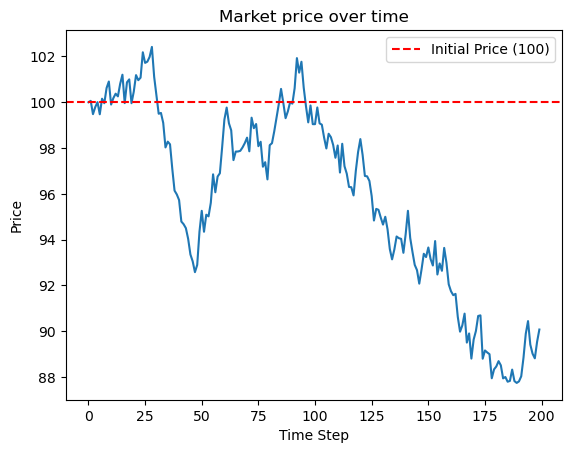

In [11]:
time_array = jnp.arange(0, 200, 1)
price_history = price_history.at[0].set(100)
print(price_history.shape, time_array.shape)

import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x = time_array, y = price_history.flatten())
plt.title('Market price over time')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.axhline(y=100, color='red', linestyle='--', label='Initial Price (100)')
plt.legend()
plt.show()
